In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
from fastai import *
from fastai.text import *
import sklearn.feature_extraction.text as sklearn_text
import pickle 
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jquin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataframes
- Two df's: df_depressed (smaller) and random_tweets_df (much larger)
- For this first iteration let's try to make a balanced dataset


In [4]:
df_depressed = pd.read_csv("depressed.csv")
print(df_depressed.shape)
df_depressed.head()

(4355, 2)


,Message,Sentiment
0,Is anyone else just too fuckin depressed to ev...,Depressed
1,Had an actually really good day today for the ...,Depressed
2,"Today, I'm still alive...",Depressed
3,"I just want to lay in bed, but I have to go to...",Depressed
4,"I'm new here. I had depression in high school,...",Depressed


In [5]:
# Filter by tweets w/ sentiment of 1
random_df = pd.read_csv("normal_sample.csv")
print(random_df.shape)
random_df.head()

(4355, 2)


,Message,Sentiment
0,Champion right there!,Normal
1,That’s so sikh,Normal
2,Reddit told me only black men are falsely accu...,Normal
3,When the US collapses Canada will be the count...,Normal
4,Plot twist: kid actually taught the dad how to...,Normal


## Combine Dataframes

In [6]:
df_combined = pd.concat([df_depressed, random_df]) 

In [28]:
# Shuffle dataset
df_combined = df_combined.sample(frac=1, random_state=10)
df_combined.head()

,Message,Sentiment
3793,"I'm Mr Meeseeks, look at me!",Normal
961,Vietnip flashbacks,Normal
570,Mackerel clouds!,Normal
3485,"Maybe the quarantine does give me some peace, ...",Depressed
936,God I hate Tik tok,Normal


In [26]:
print("Combined dataset shape:", df_combined.shape)

Combined dataset shape: (8613, 2)


In [29]:
df_combined = df_combined.drop_duplicates()
print("Dataset shape after removing duplicates:", df_combined.shape)

Dataset shape after removing duplicates: (8613, 2)


In [30]:
# Search for null values
null_columns = df_combined.columns[df_combined.isnull().any()]
df_combined[null_columns].isnull().sum()

Series([], dtype: float64)

In [11]:
df_combined = df_combined.dropna(axis=0, how='any')

In [31]:
df_combined.shape

(8613, 2)

In [ ]:
df_combined.csv

## Preprocessing

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = df_combined["Message"]
y = df_combined["Sentiment"]

In [15]:
# This is a simple 80/20 split
# X_train, y_train contains 80% of the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=10
)

# Further split 80% training set into 90% train and 10% val
# X_train_, y_train_ contain 72% of the dataset
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    stratify=y_train,
    shuffle=True,
    random_state=10
)

In [16]:
import copy
path = "C:/Users/jquin/Desktop/Projects/Twitts"

train_df = pd.DataFrame(copy.copy(X_train_))
valid_df = pd.DataFrame(copy.copy(X_val))
test_df = pd.DataFrame(copy.copy(X_test))
train_df["Sentiment"] = list(y_train_)
valid_df["Sentiment"] = list(y_val)
test_df["Sentiment"] = list(y_test)

In [17]:
print("Balanced dataframe samples:", df_combined.shape[0])
print("Training set samples:", train_df.shape[0])
print("Test set samples:", test_df.shape[0])
print("Validation set samples:", valid_df.shape[0])

assert train_df.shape[0] + valid_df.shape[0] + test_df.shape[0] == df_combined.shape[0]
assert valid_df.shape[0] + train_df.shape[0] == X_train.shape[0]

Balanced dataframe samples: 8613
Training set samples: 6201
Test set samples: 1723
Validation set samples: 689


## Language Modelling + Classification

In [34]:
# Language model data
data_lm = TextLMDataBunch.from_df(
    path=path,
    train_df=train_df,
    valid_df=valid_df,
    test_df=test_df,
    text_cols='Message',
    label_cols='Sentiment'
)
# Classifier model data
data_clas = TextClasDataBunch.from_df(
    path=path, 
    train_df=train_df,
    valid_df=valid_df,
    test_df=test_df,
    vocab=data_lm.train_ds.vocab, 
    text_cols='Message',
    label_cols='Sentiment',
    bs=32
)

In [35]:
len(data_lm.vocab.itos)

6648

In [36]:
data_lm.show_batch()

idx,text
0,"xxbos i feel trapped and hopeless . i force myself through the motions but i do n't feel like i 'm living real life . i try to muster up positivity and motivation but the effort is always so exhausting . xxmaj everything feels exhausting . xxmaj my evenings / nights feel like just the time "" in between work "" , my time does n't feel like it belongs"
1,"i imagine that heaven will be full of people like this , so we 'll meet ... xxmaj in an another life . xxbos xxmaj she looks more sad now . xxmaj but accepting . xxbos yes i ca n’t relate to people saying they miss their life before the quarantine ( going out and doing things and hanging out with friends and going to work ) because i did"
2,"for today , will see later if i have the courage to open what 's been the issue and share it with people xxbos i do n’t get it . xxmaj how can you provide food to people who are fasting xxbos xxmaj its a wholesome post , but ca nt stop thinking about how weird it is to give people your xxunk sweat xxunk shoes and they flip out"
3,"unlike last time i ’ve had an episode of depression i do n’t feel suicidal . xxmaj idk why but to me that ’s such a good feeling for me , i miss being able to be young and dumb and feel like the worst thing in the world is the xxunk from a night before , but i ’ve not xxunk to numbing myself with xxunk drug use or"
4,"\n \n \n xxmaj it just could n’t end yet , i had something to guard . \n \n \n xxmaj but my calling has changed , and although it is painful \n \n \n xxmaj it is time to be this girl ’s xxunk angel . ” xxbos xxup ah my favourite xxunk , xxmaj xxunk and xxmaj ardito xxbos i remember hearing"


In [22]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


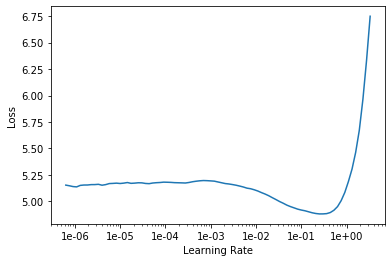

In [37]:
learner.lr_find()
learner.recorder.plot()

In [38]:
learner.fit_one_cycle(
    1, 1e-2, 
    moms=(0.8, 0.7)
)

epoch,train_loss,valid_loss,accuracy,time
0,4.286674,3.966022,0.245954,07:43


In [39]:
learner.save("ft_reddit_")
learner.save_encoder('ft_enc_reddit_')

In [40]:
learner.load("ft_reddit_")
learner.load_encoder('ft_enc_reddit_')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (6201 items)
x: LMTextList
xxbos xxmaj totally cute !,xxbos a xxrep 5 w , i miss my niece .,xxbos xxmaj so alike that at a quick glance i was wondering where you were in the second photo . 
 
  xxmaj new parent here . xxmaj just know that that hospital smile ca n't be xxunk . xxmaj that 's real joy right there he felt to have you in the world .,xxbos i feel trapped and hopeless . i force myself through the motions but i do n't feel like i 'm living real life . i try to muster up positivity and motivation but the effort is always so exhausting . xxmaj everything feels exhausting . xxmaj my evenings / nights feel like just the time " in between work " , my time does n't feel like it belongs to me . i ca n't enjoy things because i feel so much dread .,xxbos xxmaj ground the xxunk ...
y: LMLabelList
,,,,
Path: C:\Users\jquin\Desktop\Projects\Twitts;

Valid: LabelList (689 items)
x: LMTextList
xxbos xxmaj when i forgot to take meds it 

In [41]:
learner.unfreeze()
learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.990245,3.850850,0.262026,14:06


In [43]:
learner.save("ft_reddit_2_")
learner.save_encoder('ft_enc_reddit_2_')

In [46]:
learner.load("ft_reddit_2_")
learner.load_encoder('ft_enc_reddit_2_')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (6201 items)
x: LMTextList
xxbos xxmaj totally cute !,xxbos a xxrep 5 w , i miss my niece .,xxbos xxmaj so alike that at a quick glance i was wondering where you were in the second photo . 
 
  xxmaj new parent here . xxmaj just know that that hospital smile ca n't be xxunk . xxmaj that 's real joy right there he felt to have you in the world .,xxbos i feel trapped and hopeless . i force myself through the motions but i do n't feel like i 'm living real life . i try to muster up positivity and motivation but the effort is always so exhausting . xxmaj everything feels exhausting . xxmaj my evenings / nights feel like just the time " in between work " , my time does n't feel like it belongs to me . i ca n't enjoy things because i feel so much dread .,xxbos xxmaj ground the xxunk ...
y: LMLabelList
,,,,
Path: C:\Users\jquin\Desktop\Projects\Twitts;

Valid: LabelList (689 items)
x: LMTextList
xxbos xxmaj when i forgot to take meds it 

In [45]:
# learner.unfreeze()
# learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.767516,3.858725,0.262137,14:12


In [52]:
# Text classifier model
learner_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [53]:
learner_class.load_encoder('ft_enc_reddit_2_')
learner_class.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


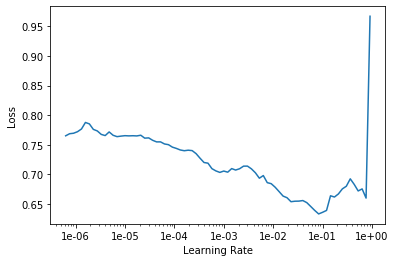

In [49]:
learner_class.lr_find()
learner_class.recorder.plot()

In [182]:
# learner_class.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.522583,0.237020,0.896952,05:58
1,0.479731,0.246238,0.904209,06:53
2,0.515673,0.244778,0.908563,05:59
3,0.396687,0.228317,0.907112,07:25
4,0.388391,0.233926,0.907112,07:03


In [50]:
learner_class.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.498547,0.282398,0.892598,07:17
1,0.462896,0.229592,0.907112,06:26
2,0.437757,0.227272,0.915820,06:59
3,0.413843,0.223600,0.918723,06:39
4,0.418993,0.243038,0.907112,06:54


In [63]:
# learner_class.save('reddit_1e-2_') 
learner_class.load('reddit_1e-2_')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6201 items)
x: TextList
xxbos xxmaj totally cute !,xxbos a xxrep 5 w , i miss my niece .,xxbos xxmaj so alike that at a quick glance i was wondering where you were in the second photo . 
 
  xxmaj new parent here . xxmaj just know that that hospital smile ca n't be xxunk . xxmaj that 's real joy right there he felt to have you in the world .,xxbos i feel trapped and hopeless . i force myself through the motions but i do n't feel like i 'm living real life . i try to muster up positivity and motivation but the effort is always so exhausting . xxmaj everything feels exhausting . xxmaj my evenings / nights feel like just the time " in between work " , my time does n't feel like it belongs to me . i ca n't enjoy things because i feel so much dread .,xxbos xxmaj ground the xxunk ...
y: CategoryList
Normal,Normal,Normal,Depressed,Normal
Path: C:\Users\jquin\Desktop\Projects\Twitts;

Valid: LabelList (689 items)
x: TextList
xxbos xxmaj whe

## Play around w/ unfreezing layers and training

In [1]:
# # Text classifier model
# learner_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# learner_class.load_encoder('ft_enc_reddit_2_')
# learner_class.load('2_layers_reddit_before_5_')
# # learner_class.freeze()

NameError: name 'text_classifier_learner' is not defined

In [57]:
# Unfreeze last 2 layers before one cycle
learner_class.freeze_to(-2)
learner_class.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.467905,0.235908,0.914369,07:45
1,0.426628,0.200657,0.934688,09:28
2,0.364146,0.219063,0.917271,07:59
3,0.316662,0.215627,0.933237,08:09
4,0.233025,0.228809,0.928882,08:29


In [86]:
# learner_class.save('2_layers_reddit_before_5_') 
learner_class.load('2_layers_reddit_before_5_')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6201 items)
x: TextList
xxbos xxmaj totally cute !,xxbos a xxrep 5 w , i miss my niece .,xxbos xxmaj so alike that at a quick glance i was wondering where you were in the second photo . 
 
  xxmaj new parent here . xxmaj just know that that hospital smile ca n't be xxunk . xxmaj that 's real joy right there he felt to have you in the world .,xxbos i feel trapped and hopeless . i force myself through the motions but i do n't feel like i 'm living real life . i try to muster up positivity and motivation but the effort is always so exhausting . xxmaj everything feels exhausting . xxmaj my evenings / nights feel like just the time " in between work " , my time does n't feel like it belongs to me . i ca n't enjoy things because i feel so much dread .,xxbos xxmaj ground the xxunk ...
y: CategoryList
Normal,Normal,Normal,Depressed,Normal
Path: C:\Users\jquin\Desktop\Projects\Twitts;

Valid: LabelList (689 items)
x: TextList
xxbos xxmaj whe

In [94]:
learner_class.load('reddit_1e-2__')

# Unfreeze last 2 layers before one cycle
learner_class.freeze_to(-2)
learner_class.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.386856,0.228566,0.915820,09:54
1,0.485679,0.219944,0.915820,07:20
2,0.397616,0.267537,0.912917,08:48
3,0.417463,0.227865,0.917271,07:57
4,0.367469,0.246909,0.899855,09:05
5,0.270721,0.206395,0.923077,10:03
6,0.292815,0.204704,0.917271,09:03
7,0.222056,0.204424,0.921626,09:35
8,0.193572,0.205041,0.917271,09:21
9,0.167520,0.220753,0.918723,08:26


In [95]:
learner_class.save("extra")

In [101]:
learner_class.load('reddit_1e-2__')

# Unfreeze last 2 layers before one cycle
learner_class.freeze_to(-2)
learner_class.fit_one_cycle(6, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.454828,0.232391,0.912917,09:00
1,0.438571,0.247123,0.901306,07:38
2,0.420213,0.256055,0.892598,08:58
3,0.336915,0.255565,0.925980,08:42
4,0.254581,0.204762,0.930334,08:26
5,0.209324,0.198980,0.927431,08:54


In [102]:
learner_class.save("extra_2")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6201 items)
x: TextList
xxbos xxmaj totally cute !,xxbos a xxrep 5 w , i miss my niece .,xxbos xxmaj so alike that at a quick glance i was wondering where you were in the second photo . 
 
  xxmaj new parent here . xxmaj just know that that hospital smile ca n't be xxunk . xxmaj that 's real joy right there he felt to have you in the world .,xxbos i feel trapped and hopeless . i force myself through the motions but i do n't feel like i 'm living real life . i try to muster up positivity and motivation but the effort is always so exhausting . xxmaj everything feels exhausting . xxmaj my evenings / nights feel like just the time " in between work " , my time does n't feel like it belongs to me . i ca n't enjoy things because i feel so much dread .,xxbos xxmaj ground the xxunk ...
y: CategoryList
Normal,Normal,Normal,Depressed,Normal
Path: C:\Users\jquin\Desktop\Projects\Twitts;

Valid: LabelList (689 items)
x: TextList
xxbos xxmaj whe

## Final Model

In [103]:
# learner_class.load('2_layers_reddit_before_5')
learner_class.load('extra_2')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jquin\\Desktop\\Projects\\Twitts\\models\\extra2.pth'

In [97]:
def cm_plot(cm, classes, cm_fig_path,
                normalize=False,
                title=None,
                cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    samples = np.sum(cm)
    accuracy = np.trace(cm) / float(np.sum(cm)) * 100
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # print('for i {} and j {} : {}'.format(i, j, cm[i,j]))
            ax.annotate(format(cm[i, j], fmt), (j, i),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")
    np.set_printoptions(precision=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('\nPredicted label\naccuracy={:0.2f}%; N={}'.format(accuracy, samples))
    lim = len(classes) - 0.5
    plt.ylim([lim, -.5])
    plt.tight_layout()
    plt.savefig(cm_fig_path)
    plt.show()
    plt.close('all')

## Validation Metrics

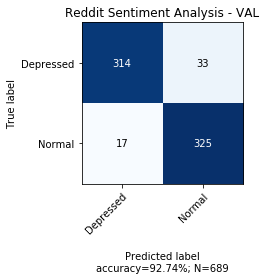

In [109]:
interp = ClassificationInterpretation.from_learner(learner_class)
cm = interp.confusion_matrix()
 
cm_plot(
    cm=cm,
    classes=np.unique(y), 
    cm_fig_path="C:/Users/jquin/Desktop/Projects/Twitts/cnf_reddit.png",
    title="Reddit Sentiment Analysis - VAL"
)

In [110]:
val_preds = []
for i in valid_df["Message"]:
    pred = learner_class.predict(i)
    val_preds.append(pred)
    print(pred)

C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7009, 0.2991]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0054, 0.9946]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1001, 0.8999]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8736, 0.1264]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9921, 0.0079]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7402, 0.2598]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7921, 0.2079]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0213, 0.9787]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9922e-01, 7.7907e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0872, 0.9128]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0927, 0.9073]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.8215e-04, 9.9912e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9899, 0.0101]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9888, 0.0112]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0060, 0.9940]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0111, 0.9889]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0880, 0.9120]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5430, 0.4570]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0229, 0.9771]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0444, 0.9556]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4494, 0.5506]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2589, 0.7411]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0159, 0.9841]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1008, 0.8992]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1739, 0.8261]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0075, 0.9925]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0686, 0.9314]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0090, 0.9910]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0151, 0.9849]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9210, 0.0790]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9629, 0.0371]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.5234e-05, 9.9993e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9507, 0.0493]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0347, 0.9653]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1720, 0.8280]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6587, 0.3412]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0936, 0.9064]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0910, 0.9090]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9974, 0.0026]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0281, 0.9719]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8311, 0.1689]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9988, 0.0012]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0015, 0.9985]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0241, 0.9759]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9710, 0.0290]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0078, 0.9922]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0945, 0.9055]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9928, 0.0072]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9503, 0.0497]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1212, 0.8788]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1395, 0.8605]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.5657e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([7.6431e-05, 9.9992e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0888, 0.9112]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6716e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0180, 0.9820]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0354, 0.9646]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9464, 0.0536]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4750, 0.5250]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0766, 0.9234]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2452, 0.7548]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0092, 0.9908]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0203, 0.9797]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9949, 0.0051]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5347, 0.4653]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0184, 0.9816]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9669, 0.0331]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0092, 0.9908]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0195, 0.9805]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1349, 0.8651]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1855, 0.8145]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0359, 0.9641]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9937, 0.0063]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9344, 0.0656]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0268, 0.9732]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0462, 0.9538]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9940, 0.0060]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9911, 0.0089]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2980, 0.7020]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0150, 0.9850]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0263, 0.9737]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9437, 0.0563]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1048, 0.8952]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9939, 0.0061]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1072, 0.8928]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0521, 0.9479]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0448, 0.9552]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0022, 0.9978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8720, 0.1280]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9983, 0.0017]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0075, 0.9925]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1102, 0.8898]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9944, 0.0056]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0243, 0.9757]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3278, 0.6722]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0133, 0.9867]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9959, 0.0041]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0034, 0.9966]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9323, 0.0677]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9983, 0.0017]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0999, 0.9001]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9694, 0.0306]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9724, 0.0276]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9592, 0.0408]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9767, 0.0233]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.2216e-05, 9.9992e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9943, 0.0057]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9870, 0.0130]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0108, 0.9892]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0403, 0.9597]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9677, 0.0323]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.7626e-04, 9.9982e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2526, 0.7474]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0090, 0.9910]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9739, 0.0261]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0237, 0.9763]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9928, 0.0072]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8762, 0.1238]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9384, 0.0616]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9403, 0.0597]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.4634e-04, 9.9985e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9894, 0.0106]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0064, 0.9936]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4682, 0.5318]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9459, 0.0541]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9590, 0.0410]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0794, 0.9206]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9289, 0.0711]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0541, 0.9459]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9963e-01, 3.7474e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9943, 0.0057]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0078, 0.9922]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1934, 0.8066]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.1573e-04, 9.9948e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0123, 0.9877]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0020, 0.9980]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9960, 0.0040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9861, 0.0139]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1090, 0.8910]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9886, 0.0114]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0720, 0.9280]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0127, 0.9873]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9914, 0.0086]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9851, 0.0149]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0857, 0.9143]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9614, 0.0386]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.2829e-04, 9.9987e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1200, 0.8800]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0203, 0.9797]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0144, 0.9856]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0116, 0.9884]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0753, 0.9247]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0298, 0.9702]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9979, 0.0021]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2363, 0.7637]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6420, 0.3580]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4871, 0.5129]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8818, 0.1182]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6716e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3426, 0.6574]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3805, 0.6195]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3570, 0.6430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0956, 0.9044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9865, 0.0135]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9992e-01, 8.4628e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9861, 0.0139]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9648, 0.0352]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.0453e-04, 9.9950e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9831, 0.0169]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0181, 0.9819]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9800, 0.0200]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9933, 0.0067]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0750, 0.9250]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0026, 0.9974]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9142, 0.0858]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9766, 0.0234]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0536, 0.9464]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6281, 0.3719]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9924, 0.0076]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2360, 0.7640]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9950e-01, 5.0096e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0707, 0.9293]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1206, 0.8794]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0886, 0.9114]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9985, 0.0015]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9977, 0.0023]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0463, 0.9537]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9907, 0.0093]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0169, 0.9831]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0160, 0.9840]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9928, 0.0072]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0740, 0.9260]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9918, 0.0082]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1021, 0.8979]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7769, 0.2231]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0140, 0.9860]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.4244e-04, 9.9956e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.2565e-04, 9.9987e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0037, 0.9963]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0269, 0.9731]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3838, 0.6162]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0384, 0.9616]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0228, 0.9772]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9978, 0.0022]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8973, 0.1027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3359, 0.6641]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3888, 0.6112]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2169, 0.7831]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0075, 0.9925]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4253, 0.5747]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2128, 0.7872]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.8506e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8777, 0.1223]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1905, 0.8095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.4376e-05, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0642, 0.9358]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0244, 0.9756]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0078, 0.9922]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9974, 0.0026]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0046, 0.9954]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1043, 0.8957]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0322, 0.9678]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0365, 0.9635]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9920, 0.0080]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0353, 0.9647]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9899, 0.0101]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9257, 0.0743]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0316, 0.9684]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.9848e-04, 9.9940e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6716e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9903, 0.0097]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2877, 0.7123]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8882, 0.1118]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9952, 0.0048]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0452, 0.9548]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9848, 0.0152]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0203, 0.9797]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0615, 0.9385]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1163, 0.8837]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.5764e-05, 9.9994e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.4075e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0011, 0.9989]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0057, 0.9943]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9814, 0.0186]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0029, 0.9971]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6534, 0.3466]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9341, 0.0659]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9911e-01, 8.8747e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8896, 0.1104]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4261, 0.5739]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0317, 0.9683]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0018, 0.9982]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9989e-01, 1.0530e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9521, 0.0479]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0211, 0.9789]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0172, 0.9828]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9611, 0.0389]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0132, 0.9868]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9955, 0.0045]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0040, 0.9960]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0011, 0.9989]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9835, 0.0165]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1229, 0.8771]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0746, 0.9254]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9645, 0.0355]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9831, 0.0169]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0205, 0.9795]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0102, 0.9898]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9856, 0.0144]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8211, 0.1789]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0250, 0.9750]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9777, 0.0223]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0065, 0.9935]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9835, 0.0165]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.3995e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7654, 0.2346]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0213, 0.9787]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0482, 0.9518]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0616, 0.9384]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0327, 0.9673]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9911, 0.0089]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9608, 0.0392]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0418, 0.9582]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9930, 0.0070]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1161, 0.8839]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0029, 0.9971]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2862, 0.7138]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8176, 0.1824]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0079, 0.9921]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9913e-01, 8.7247e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9818, 0.0182]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9922, 0.0078]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9951, 0.0049]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9698, 0.0302]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8445, 0.1555]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9948e-01, 5.2199e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0096, 0.9904]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0276, 0.9724]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0186, 0.9814]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0314, 0.9686]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0084, 0.9916]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0159, 0.9841]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6970, 0.3030]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4228, 0.5772]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0055, 0.9945]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0305, 0.9695]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0318, 0.9682]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0386, 0.9614]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0278, 0.9722]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0536, 0.9464]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1439, 0.8561]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9938, 0.0062]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1604, 0.8396]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1686, 0.8314]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9447, 0.0553]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0470, 0.9530]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9257, 0.0743]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0337, 0.9663]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9452, 0.0548]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0238, 0.9762]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8869, 0.1131]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9611, 0.0389]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0766, 0.9234]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9740, 0.0260]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0315, 0.9685]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9850, 0.0150]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9868, 0.0132]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9719, 0.0281]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9684, 0.0316]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9985, 0.0015]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0015, 0.9985]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8703, 0.1297]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0104, 0.9896]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9478, 0.0522]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9989, 0.0011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0630, 0.9370]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0221, 0.9779]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9825, 0.0175]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9795, 0.0205]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9795, 0.0205]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9941, 0.0059]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9964, 0.0036]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0115, 0.9885]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2687, 0.7313]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9922, 0.0078]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8379, 0.1621]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8181, 0.1819]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0201, 0.9799]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.2248e-04, 9.9968e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1761, 0.8239]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9744, 0.0256]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0026, 0.9974]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9919, 0.0081]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9806, 0.0194]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9260, 0.0740]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1437, 0.8563]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8867, 0.1133]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8647, 0.1353]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9943e-01, 5.7292e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0213, 0.9787]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9244, 0.0756]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1618, 0.8382]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3524, 0.6476]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0072, 0.9928]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9980, 0.0020]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9897, 0.0103]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1517, 0.8483]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.0431e-05, 9.9997e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.8775e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9979, 0.0021]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0959, 0.9041]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9944, 0.0056]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1064, 0.8936]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0087, 0.9913]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0211, 0.9789]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0191, 0.9809]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5617, 0.4383]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9559, 0.0441]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1783, 0.8217]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2717, 0.7283]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8835, 0.1165]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9315, 0.0685]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8218, 0.1782]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0110, 0.9890]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0022, 0.9978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8275, 0.1725]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0051, 0.9949]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0182, 0.9818]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.9421e-05, 9.9993e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0098, 0.9902]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0029, 0.9971]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0306, 0.9694]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9697, 0.0303]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9466, 0.0534]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0013, 0.9987]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9944, 0.0056]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9904, 0.0096]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0255, 0.9745]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9702, 0.0298]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0093, 0.9907]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1275, 0.8725]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9508, 0.0492]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0339, 0.9661]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9934e-01, 6.6134e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9711, 0.0289]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9957, 0.0043]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0215, 0.9785]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0069, 0.9931]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9985e-01, 1.4503e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0054, 0.9946]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0454, 0.9546]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9962, 0.0038]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0370, 0.9630]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9468, 0.0532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6831, 0.3169]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9647, 0.0353]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9873, 0.0127]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9701, 0.0299]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6716e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9774, 0.0226]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0602, 0.9398]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.5840e-08, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9890, 0.0110]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9685, 0.0315]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0309, 0.9691]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0239, 0.9761]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9882, 0.0118]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9862, 0.0138]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9465, 0.0535]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9830, 0.0170]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0019, 0.9981]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0576, 0.9424]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9956e-01, 4.4329e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2329, 0.7671]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9805, 0.0195]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9960e-01, 4.0002e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9941, 0.0059]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0987, 0.9013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0222, 0.9778]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0046, 0.9954]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0420, 0.9580]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0491, 0.9509]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.6789e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9956, 0.0044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9846, 0.0154]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.8884e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0287, 0.9713]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0259, 0.9741]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3365, 0.6635]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0436, 0.9564]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9650, 0.0350]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9398, 0.0602]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9879, 0.0121]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9568, 0.0432]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8360, 0.1640]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9896, 0.0104]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0384, 0.9616]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1215, 0.8785]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0165, 0.9835]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0120, 0.9880]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0783, 0.9217]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9767, 0.0233]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0028, 0.9972]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8260, 0.1740]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9752, 0.0248]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0171, 0.9829]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9903, 0.0097]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9900, 0.0100]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1453, 0.8547]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0028, 0.9972]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9503, 0.0497]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0254, 0.9746]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0826, 0.9174]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0798, 0.9202]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0668, 0.9332]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.2528e-04, 9.9977e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9422, 0.0578]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0329, 0.9671]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9880, 0.0120]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9797, 0.0203]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0157, 0.9843]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9855, 0.0145]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0100, 0.9900]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0292, 0.9708]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0027, 0.9973]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8676, 0.1324]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9401, 0.0599]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0099, 0.9901]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9932, 0.0068]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9922, 0.0078]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0523, 0.9477]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.0179e-05, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9767, 0.0233]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0661, 0.9339]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9059, 0.0941]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9559, 0.0441]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9297, 0.0703]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0145, 0.9855]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5875, 0.4125]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0235, 0.9765]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9843, 0.0157]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.2075e-04, 9.9958e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9981, 0.0019]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9938, 0.0062]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9853, 0.0147]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0055, 0.9945]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9868, 0.0132]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0075, 0.9925]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8082, 0.1918]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9922, 0.0078]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9911, 0.0089]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0064, 0.9936]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9864, 0.0136]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9961, 0.0039]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0606, 0.9394]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9212, 0.0788]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0585, 0.9415]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1633, 0.8367]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9283, 0.0717]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9879, 0.0121]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9935, 0.0065]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0271, 0.9729]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9471, 0.0529]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0022, 0.9978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0575, 0.9425]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0286, 0.9714]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8135, 0.1865]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9987, 0.0013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9591, 0.0409]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1735, 0.8265]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0858, 0.9142]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0495, 0.9505]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9862, 0.0138]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.6995e-04, 9.9973e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0389, 0.9611]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9782, 0.0218]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0518, 0.9482]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9722, 0.0278]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6716e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8673, 0.1327]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9570, 0.0430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9989, 0.0011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6863, 0.3137]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9940, 0.0060]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0029, 0.9971]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9416, 0.0584]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.7497e-05, 9.9993e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9689, 0.0311]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9837, 0.0163]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9986, 0.0014]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0121, 0.9879]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9905e-01, 9.5416e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9967e-01, 3.3471e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9952, 0.0048]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0027, 0.9973]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0020, 0.9980]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2146, 0.7854]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0594, 0.9406]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0342, 0.9658]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0587, 0.9413]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0966, 0.9034]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9637, 0.0363]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0428, 0.9572]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9987, 0.0013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7313, 0.2687]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1463, 0.8537]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9432, 0.0568]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0665, 0.9335]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0137, 0.9863]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7768, 0.2232]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9604, 0.0396]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0894, 0.9106]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9887, 0.0113]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1469, 0.8531]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9877, 0.0123]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9646, 0.0354]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9666, 0.0334]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0209, 0.9791]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0109, 0.9891]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9636, 0.0364]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0594, 0.9406]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9851, 0.0149]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0127, 0.9873]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9000, 0.1000]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0229, 0.9771]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7072, 0.2928]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0068, 0.9932]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9934, 0.0066]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1193, 0.8807]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9688, 0.0312]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6541, 0.3459]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9968, 0.0032]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0119, 0.9881]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9947, 0.0053]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0095, 0.9905]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.8665e-08]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0114, 0.9886]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9996e-01, 3.7314e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0100, 0.9900]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9981, 0.0019]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9650, 0.0350]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9624, 0.0376]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9795, 0.0205]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9979e-01, 2.0698e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9999e-01, 1.0657e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0875, 0.9125]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0196, 0.9804]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9958, 0.0042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8836, 0.1164]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5108, 0.4892]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9934, 0.0066]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0012, 0.9988]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0091, 0.9909]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9489, 0.0511]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8779, 0.1221]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7635, 0.2365]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8795, 0.1205]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0697, 0.9303]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9847, 0.0153]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8839, 0.1161]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0091, 0.9909]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0057, 0.9943]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.7747e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9734, 0.0266]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0306, 0.9694]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9713, 0.0287]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9945, 0.0055]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0060, 0.9940]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1936, 0.8064]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9801, 0.0199]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8572, 0.1428]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9711, 0.0289]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9975, 0.0025]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0113, 0.9887]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0339, 0.9661]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3279, 0.6721]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9248, 0.0752]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9834, 0.0166]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3513, 0.6487]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9929, 0.0071]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9960, 0.0040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8688, 0.1312]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0574, 0.9426]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0035, 0.9965]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9958, 0.0042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0914, 0.9086]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9684, 0.0316]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7120, 0.2880]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0039, 0.9961]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9563, 0.0437]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.4853e-04, 9.9945e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.5134e-05, 9.9991e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0078, 0.9922]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9945, 0.0055]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0451, 0.9549]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9924e-01, 7.5869e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0208, 0.9792]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0081, 0.9919]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9667, 0.0333]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0088, 0.9912]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9905, 0.0095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.5756e-04, 9.9914e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0982, 0.9018]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9576, 0.0424]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9927, 0.0073]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.5701e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0560, 0.9440]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9890, 0.0110]))


In [111]:
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

In [112]:
val_accuracy = balanced_accuracy_score(
        [0 if i == "Depressed" else 1 for i in valid_df["Sentiment"]], 
        [int(i[0]) for i in val_preds]
    )
print("-----------------------------------------------------------------")
print("RNN Validation Accuracy: %.2f%%" % (val_accuracy * 100.0))
print("-----------------------------------------------------------------")
print(
    classification_report(
        [0 if i == "Depressed" else 1 for i in valid_df["Sentiment"]], 
        [int(i[0]) for i in val_preds],
        target_names=list(np.unique(y))
    )
)

-----------------------------------------------------------------
RNN Validation Accuracy: 92.76%
-----------------------------------------------------------------
              precision    recall  f1-score   support

   Depressed       0.95      0.90      0.93       347
      Normal       0.90      0.96      0.93       342

    accuracy                           0.93       689
   macro avg       0.93      0.93      0.93       689
weighted avg       0.93      0.93      0.93       689



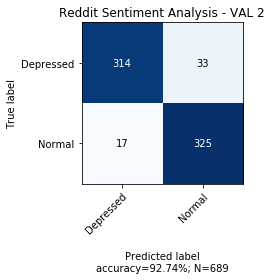

In [113]:
interp = ClassificationInterpretation.from_learner(learner_class)
cm = interp.confusion_matrix()
 
cm_plot(
    cm=cm,
    classes=np.unique(y), 
    cm_fig_path="C:/Users/jquin/Desktop/Projects/Twitts/cnf_reddit.png",
    title="Reddit Sentiment Analysis - VAL 2"
)

## Test Metrics

C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6880, 0.3120]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9036, 0.0964]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9921, 0.0079]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8704, 0.1296]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0328, 0.9672]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1475, 0.8525]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9921, 0.0079]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 3.5859e-09]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9730, 0.0270]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9820, 0.0180]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0061, 0.9939]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.2169e-08, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0905, 0.9095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9834, 0.0166]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9858, 0.0142]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0318, 0.9682]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9107, 0.0893]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9966e-01, 3.4001e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1041, 0.8959]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0468, 0.9532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0365, 0.9635]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9980, 0.0020]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9948e-01, 5.2022e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9987, 0.0013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0149, 0.9851]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6852, 0.3148]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0447, 0.9553]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8942, 0.1058]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4867, 0.5133]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9947, 0.0053]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9360, 0.0640]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9910, 0.0090]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9980, 0.0020]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9972, 0.0028]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([9.8377e-05, 9.9990e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0023, 0.9977]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9732, 0.0268]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0080, 0.9920]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0186, 0.9814]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0453, 0.9547]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9644, 0.0356]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0543, 0.9457]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8878, 0.1122]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9983, 0.0017]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6431, 0.3569]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0273, 0.9727]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5136, 0.4864]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9352, 0.0648]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9898, 0.0102]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.7783e-14, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9979e-01, 2.1193e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0134, 0.9866]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9899, 0.0101]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0167, 0.9833]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4445, 0.5555]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8340, 0.1660]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0811, 0.9189]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9118, 0.0882]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9947, 0.0053]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.1091e-05, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0060, 0.9940]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9958, 0.0042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2491, 0.7509]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0123, 0.9877]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0058, 0.9942]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0020, 0.9980]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0692, 0.9308]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9393, 0.0607]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9905, 0.0095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9701, 0.0299]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9867, 0.0133]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9963e-01, 3.6695e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9730, 0.0270]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9347, 0.0653]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0075, 0.9925]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1199, 0.8801]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9988e-01, 1.1507e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0016, 0.9984]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9904e-01, 9.6382e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0061, 0.9939]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9661, 0.0339]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9982, 0.0018]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9997e-01, 2.6942e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0386, 0.9614]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5538, 0.4462]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0083, 0.9917]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9714, 0.0286]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0087, 0.9913]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1058, 0.8942]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9377, 0.0623]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0063, 0.9937]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4186, 0.5814]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8439, 0.1561]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0960, 0.9040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9667, 0.0333]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2716, 0.7284]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0025, 0.9975]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9973, 0.0027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9626, 0.0374]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0038, 0.9962]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0447, 0.9553]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9881, 0.0119]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9821, 0.0179]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9927, 0.0073]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0532, 0.9468]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0039, 0.9961]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0418, 0.9582]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0776, 0.9224]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0515, 0.9485]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9918, 0.0082]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9840, 0.0160]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0305, 0.9695]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9301, 0.0699]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3326, 0.6674]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0013, 0.9987]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1527, 0.8473]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9261, 0.0739]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0707, 0.9293]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8956, 0.1044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0712, 0.9288]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9953e-01, 4.6834e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5121, 0.4879]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0016, 0.9984]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0011, 0.9989]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0648, 0.9352]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9516, 0.0484]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0339, 0.9661]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0093, 0.9907]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9987, 0.0013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9990e-01, 1.0042e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0411, 0.9589]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0135, 0.9865]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0074, 0.9926]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1792, 0.8208]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0973, 0.9027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.5469e-04, 9.9935e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1016, 0.8984]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9970, 0.0030]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9435, 0.0565]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9722, 0.0278]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.9389e-04, 9.9971e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9779, 0.0221]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0123, 0.9877]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9788, 0.0212]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0111, 0.9889]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2166, 0.7834]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0827, 0.9173]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0249, 0.9751]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0019, 0.9981]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0014, 0.9986]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0160, 0.9840]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0428, 0.9572]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0506, 0.9494]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0147, 0.9853]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.2618e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0364, 0.9636]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0111, 0.9889]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9882, 0.0118]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9972, 0.0028]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0168, 0.9832]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7368, 0.2632]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0018, 0.9982]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9944, 0.0056]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0158, 0.9842]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9867, 0.0133]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9944, 0.0056]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0238, 0.9762]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0144, 0.9856]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0423, 0.9577]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1329, 0.8671]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0013, 0.9987]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9748, 0.0252]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2419, 0.7581]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0291, 0.9709]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0483, 0.9517]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9914e-01, 8.6341e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0028, 0.9972]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0027, 0.9973]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0305, 0.9695]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0192, 0.9808]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0462, 0.9538]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8247, 0.1753]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9722, 0.0278]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1558, 0.8442]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3597, 0.6403]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1198, 0.8802]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9847, 0.0153]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2729, 0.7271]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9955, 0.0045]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8340, 0.1660]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0077, 0.9923]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2870, 0.7130]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9573, 0.0427]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9744, 0.0256]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9476, 0.0524]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0745, 0.9255]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9897, 0.0103]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0193, 0.9807]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9876, 0.0124]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0128, 0.9872]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2281, 0.7719]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2626, 0.7374]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.2926e-04, 9.9977e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2141, 0.7859]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.3290e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0011, 0.9989]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7585, 0.2415]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9338, 0.0662]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9531, 0.0469]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0764, 0.9236]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0099, 0.9901]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9506, 0.0494]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0369, 0.9631]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9374, 0.0626]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0013, 0.9987]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3361, 0.6639]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9939, 0.0061]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7178, 0.2822]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0043, 0.9957]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9061, 0.0939]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0140, 0.9860]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 5.7386e-07]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9965, 0.0035]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0057, 0.9943]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9988e-01, 1.1673e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0772, 0.9228]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6676, 0.3324]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6472, 0.3528]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0279, 0.9721]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9028, 0.0972]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0204, 0.9796]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8676, 0.1324]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0394, 0.9606]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9982, 0.0018]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.3933e-05, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1369, 0.8631]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8366, 0.1634]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9985e-01, 1.5178e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6034, 0.3966]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9943, 0.0057]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0279, 0.9721]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0077, 0.9923]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9722, 0.0278]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0334, 0.9666]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9840, 0.0160]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.6023e-05, 9.9997e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0116, 0.9884]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0427, 0.9573]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.0549e-05, 9.9994e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0150, 0.9850]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9392, 0.0608]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3797, 0.6203]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9943, 0.0057]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1172, 0.8828]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0177, 0.9823]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0033, 0.9967]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9973e-01, 2.7374e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0142, 0.9858]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0064, 0.9936]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1025, 0.8975]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0449, 0.9551]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7808, 0.2192]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0279, 0.9721]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0373, 0.9627]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0632, 0.9368]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9563, 0.0437]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0754, 0.9246]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0248, 0.9752]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0197, 0.9803]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9997e-01, 3.1408e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9916e-01, 8.4438e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0171, 0.9829]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9909, 0.0091]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.9280e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0164, 0.9836]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9299, 0.0701]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9937e-01, 6.3124e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9981e-01, 1.8527e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9905, 0.0095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9902e-01, 9.8244e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9958, 0.0042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9175, 0.0825]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1542, 0.8458]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0294, 0.9706]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9745, 0.0255]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0207, 0.9793]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6240, 0.3760]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9985, 0.0015]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9844, 0.0156]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9941e-01, 5.8925e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9344, 0.0656]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9959e-01, 4.0644e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0033, 0.9967]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([7.1024e-04, 9.9929e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0155, 0.9845]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6155, 0.3845]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0085, 0.9915]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9747, 0.0253]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9710, 0.0290]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9424, 0.0576]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0917, 0.9083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2300, 0.7700]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0049, 0.9951]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.5369e-04, 9.9975e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9821, 0.0179]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9780, 0.0220]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9974, 0.0026]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0250, 0.9750]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4780, 0.5220]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9514, 0.0486]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.5421e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0114, 0.9886]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9970, 0.0030]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0637, 0.9363]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0098, 0.9902]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9647, 0.0353]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9959, 0.0041]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0421, 0.9579]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9978e-01, 2.1841e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0702, 0.9298]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9845, 0.0155]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9706, 0.0294]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9796, 0.0204]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9524, 0.0476]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9513, 0.0487]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6864, 0.3136]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0014, 0.9986]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0425, 0.9575]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9833, 0.0167]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9803, 0.0197]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7617, 0.2383]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 6.6173e-07]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9907, 0.0093]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0031, 0.9969]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9995e-01, 5.3670e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9979e-01, 2.1040e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1887, 0.8113]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8627, 0.1373]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9514, 0.0486]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0102, 0.9898]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2340, 0.7660]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7934, 0.2066]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9860, 0.0140]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0019, 0.9981]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9763, 0.0237]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9001, 0.0999]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9864, 0.0136]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1691, 0.8309]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7977, 0.2023]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9889, 0.0111]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9934, 0.0066]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1892, 0.8108]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4838, 0.5162]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0316, 0.9684]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9826, 0.0174]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9250, 0.0750]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.8695e-07, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0027, 0.9973]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9729, 0.0271]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4426, 0.5574]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8296, 0.1704]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9984, 0.0016]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0089, 0.9911]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0200, 0.9800]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0078, 0.9922]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9747, 0.0253]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0469, 0.9531]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1426, 0.8574]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8472, 0.1528]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0905, 0.9095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9962e-01, 3.7571e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0063, 0.9937]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9883, 0.0117]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1806, 0.8194]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0371, 0.9629]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2736, 0.7264]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7125, 0.2875]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9759, 0.0241]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9902, 0.0098]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1663, 0.8337]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5443, 0.4557]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9856, 0.0144]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3195, 0.6805]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0765, 0.9235]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9882, 0.0118]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9897, 0.0103]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0065, 0.9935]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7790, 0.2210]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9989e-01, 1.0835e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0034, 0.9966]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3417, 0.6583]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9777, 0.0223]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0812, 0.9188]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9942, 0.0058]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2797, 0.7203]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0766, 0.9234]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0890, 0.9110]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1642, 0.8358]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9308, 0.0692]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0274, 0.9726]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9882, 0.0118]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9956, 0.0044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9913, 0.0087]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0259, 0.9741]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1744, 0.8256]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9872, 0.0128]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9889, 0.0111]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4246, 0.5754]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9996e-01, 4.1150e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0879, 0.9121]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0056, 0.9944]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0755, 0.9245]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0569, 0.9431]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9958, 0.0042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0426, 0.9574]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9723, 0.0277]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9680, 0.0320]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0422, 0.9578]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.2199e-04, 9.9978e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9707, 0.0293]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9623, 0.0377]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.8364e-04, 9.9912e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9970, 0.0030]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.8867e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9930, 0.0070]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3248, 0.6752]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0028, 0.9972]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3056, 0.6944]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9359, 0.0641]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9824, 0.0176]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9736, 0.0264]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0877, 0.9123]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0041, 0.9959]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9196, 0.0804]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9088, 0.0912]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9820, 0.0180]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9957e-01, 4.3146e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9965e-01, 3.4512e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.0364e-04, 9.9970e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3424, 0.6576]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8078, 0.1922]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0029, 0.9971]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9514, 0.0486]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4628, 0.5372]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0741, 0.9259]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9880, 0.0120]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0783, 0.9217]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9626, 0.0374]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6198, 0.3802]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9994e-01, 6.0331e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0477, 0.9523]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0084, 0.9916]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0238, 0.9762]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9907, 0.0093]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0046, 0.9954]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1412, 0.8588]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0019, 0.9981]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.6188e-06, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0347, 0.9653]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9839, 0.0161]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9921, 0.0079]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0387, 0.9613]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1732, 0.8268]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1065, 0.8935]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9990, 0.0010]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9296, 0.0704]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0097, 0.9903]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9989, 0.0011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8764, 0.1236]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9080, 0.0920]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.3764e-07, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0063, 0.9937]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9904e-01, 9.6331e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0276, 0.9724]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3142, 0.6858]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0017, 0.9983]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0049, 0.9951]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9872, 0.0128]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0293, 0.9707]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9773, 0.0227]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0020, 0.9980]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9801, 0.0199]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0509, 0.9491]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9859, 0.0141]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9996e-01, 4.3476e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5604, 0.4396]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9235, 0.0765]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9382, 0.0618]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9774, 0.0226]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9286, 0.0714]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1226, 0.8774]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0068, 0.9932]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6725, 0.3275]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0735, 0.9265]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5209, 0.4791]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0178, 0.9822]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0352, 0.9648]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6856, 0.3144]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0405, 0.9595]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.2905e-04, 9.9917e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5539, 0.4461]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9956, 0.0044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0061, 0.9939]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8816, 0.1184]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9179, 0.0821]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5360, 0.4640]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.0148e-05, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9864, 0.0136]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9939, 0.0061]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0360, 0.9640]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0327, 0.9673]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0201, 0.9799]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4171, 0.5829]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9329, 0.0671]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0016, 0.9984]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.3778e-09, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9283, 0.0717]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3298, 0.6702]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0422, 0.9578]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9899, 0.0101]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9725, 0.0275]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1037, 0.8963]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.5150e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5583, 0.4417]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7750, 0.2250]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0099, 0.9901]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0490, 0.9510]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.7178e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9920, 0.0080]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8636, 0.1364]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9614, 0.0386]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0404, 0.9596]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0256, 0.9744]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9936, 0.0064]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9395, 0.0605]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9881, 0.0119]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9910, 0.0090]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8926, 0.1074]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0082, 0.9918]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9974, 0.0026]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9895, 0.0105]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2178, 0.7822]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9570, 0.0430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9969, 0.0031]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0139, 0.9861]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0176, 0.9824]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0313, 0.9687]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9528, 0.0472]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0044, 0.9956]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9860, 0.0140]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9579, 0.0421]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0038, 0.9962]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0257, 0.9743]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0124, 0.9876]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0216, 0.9784]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8318, 0.1682]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9990, 0.0010]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0191, 0.9809]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8385, 0.1615]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8977, 0.1023]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9913e-01, 8.6833e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9979, 0.0021]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8476, 0.1524]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9976, 0.0024]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7937, 0.2063]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1289, 0.8711]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0846, 0.9154]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9223, 0.0777]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0084, 0.9916]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9959e-01, 4.0619e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9978, 0.0022]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.0569e-04, 9.9959e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9798, 0.0202]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0105, 0.9895]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1088, 0.8912]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0319, 0.9681]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9951, 0.0049]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6716e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1425, 0.8575]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7567, 0.2433]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7911, 0.2089]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9845, 0.0155]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9881, 0.0119]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0212, 0.9788]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9121, 0.0879]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8503, 0.1497]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9945e-01, 5.4947e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9811, 0.0189]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9813, 0.0187]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0106, 0.9894]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0017, 0.9983]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0193, 0.9807]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9069, 0.0931]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0854, 0.9146]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5135, 0.4865]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9955, 0.0045]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0038, 0.9962]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.3420e-04, 9.9957e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0477, 0.9523]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0220, 0.9780]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.5802e-04, 9.9964e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0011, 0.9989]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9730, 0.0270]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8068, 0.1932]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6383, 0.3617]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2709, 0.7291]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9981, 0.0019]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2620, 0.7380]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5668, 0.4332]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0018, 0.9982]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0395, 0.9605]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1755, 0.8245]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9936, 0.0064]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0273, 0.9727]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0177, 0.9823]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.2914e-04, 9.9917e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2342, 0.7658]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9879, 0.0121]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9829, 0.0171]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2871, 0.7129]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9441, 0.0559]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9841, 0.0159]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0166, 0.9834]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0015, 0.9985]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9999e-01, 7.8732e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9733, 0.0267]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0502, 0.9498]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0352, 0.9648]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0335, 0.9665]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1610, 0.8390]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0510, 0.9490]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0320, 0.9680]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0656, 0.9344]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1422, 0.8578]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9888, 0.0112]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.1255e-04, 9.9989e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0450, 0.9550]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9704, 0.0296]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0143, 0.9857]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0325, 0.9675]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9716, 0.0284]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3743, 0.6257]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9909, 0.0091]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9828, 0.0172]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7978, 0.2022]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0060, 0.9940]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.7383e-05, 9.9997e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5300, 0.4700]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0852, 0.9148]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9743, 0.0257]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1618, 0.8382]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0570, 0.9430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0442, 0.9558]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9913, 0.0087]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0453, 0.9547]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9570, 0.0430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9936e-01, 6.3975e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9812, 0.0188]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0039, 0.9961]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7879, 0.2121]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8413, 0.1587]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0088, 0.9912]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5535, 0.4465]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9923, 0.0077]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1036, 0.8964]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.7878e-04, 9.9952e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0177, 0.9823]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8939, 0.1061]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9876, 0.0124]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0441, 0.9559]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8603, 0.1397]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0573, 0.9427]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0991, 0.9008]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0013, 0.9987]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7209, 0.2791]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6039, 0.3961]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0241, 0.9759]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0278, 0.9722]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9528, 0.0472]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.8120e-04, 9.9952e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7341, 0.2659]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([9.5407e-04, 9.9905e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9469, 0.0531]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0127, 0.9873]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0172, 0.9828]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9970e-01, 3.0298e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1354, 0.8646]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9716, 0.0284]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0327, 0.9673]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0122, 0.9878]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9929, 0.0071]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0075, 0.9925]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9967e-01, 3.3455e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9463, 0.0537]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9594, 0.0406]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0211, 0.9789]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9964, 0.0036]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0942, 0.9058]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1073, 0.8927]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0977, 0.9023]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0456, 0.9544]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0430, 0.9570]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4096, 0.5904]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9938, 0.0062]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9250, 0.0750]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0042, 0.9958]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9872, 0.0128]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9844, 0.0156]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0195, 0.9805]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9981, 0.0019]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0113, 0.9887]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0098, 0.9902]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9741, 0.0259]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9991e-01, 8.5728e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0145, 0.9855]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.7002e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9911, 0.0089]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0453, 0.9547]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9988, 0.0012]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9947, 0.0053]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7573, 0.2427]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9397, 0.0603]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0650, 0.9350]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.4024e-04, 9.9936e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9938e-01, 6.1947e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0083, 0.9917]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1650, 0.8350]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5305, 0.4695]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9823, 0.0177]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0842, 0.9158]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0651, 0.9349]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9975e-01, 2.5386e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0054, 0.9946]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9968, 0.0032]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9979, 0.0021]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8397, 0.1603]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9996e-01, 3.5387e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1241, 0.8759]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9521, 0.0479]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9929, 0.0071]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9869, 0.0131]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9280, 0.0720]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0363, 0.9637]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0150, 0.9850]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3809, 0.6191]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7800, 0.2200]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0175, 0.9825]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0412, 0.9588]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0043, 0.9957]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9768, 0.0232]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.8827e-05, 9.9995e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9936e-01, 6.4479e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0155, 0.9845]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0084, 0.9916]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 3.1263e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9892, 0.0108]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2662, 0.7338]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1142, 0.8858]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9989e-01, 1.0731e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0024, 0.9976]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0303, 0.9697]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0772, 0.9228]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0141, 0.9859]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2397, 0.7603]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9947e-01, 5.2919e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2913, 0.7087]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9998e-01, 1.6615e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0916, 0.9084]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0555, 0.9445]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9874, 0.0126]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9971e-01, 2.9211e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1110, 0.8890]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0504, 0.9496]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9945, 0.0055]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0277, 0.9723]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0572, 0.9428]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9673, 0.0327]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9718, 0.0282]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0034, 0.9966]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9867, 0.0133]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0366, 0.9634]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7450, 0.2550]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9991e-01, 8.7201e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0234, 0.9766]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8884, 0.1116]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9674, 0.0326]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9736, 0.0264]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.9748e-05, 9.9997e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0331, 0.9669]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0137, 0.9863]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0188, 0.9812]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9891, 0.0109]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0468, 0.9532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9222, 0.0778]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5446, 0.4554]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9990e-01, 1.0069e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8681, 0.1319]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3579, 0.6421]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9979, 0.0021]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9790, 0.0210]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0470, 0.9530]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9933, 0.0067]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.2558e-04, 9.9967e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2777, 0.7223]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0098, 0.9902]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1056, 0.8944]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9273, 0.0727]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0098, 0.9902]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9964, 0.0036]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7962, 0.2038]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9917e-01, 8.2891e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9966, 0.0034]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0300, 0.9700]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9849, 0.0151]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9148, 0.0852]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.4578e-04, 9.9985e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0873, 0.9127]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9837, 0.0163]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9772, 0.0228]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3586, 0.6414]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9999e-01, 9.3329e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0091, 0.9909]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0022, 0.9978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9733, 0.0267]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9962, 0.0038]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0225, 0.9775]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0348, 0.9652]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0113, 0.9887]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0139, 0.9861]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9949, 0.0051]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0181, 0.9819]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8975, 0.1025]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3858, 0.6142]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9686, 0.0314]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9488, 0.0512]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0389, 0.9611]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0442, 0.9558]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9979, 0.0021]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9828, 0.0172]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9788, 0.0212]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9820, 0.0180]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9094, 0.0906]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8876, 0.1124]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0268, 0.9732]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0165, 0.9835]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9951, 0.0049]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0389, 0.9611]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9887, 0.0113]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8511, 0.1489]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1012, 0.8988]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8819, 0.1181]))
(Category tensor(1), tensor(1), tensor([0.0398, 0.9602]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0419, 0.9581]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0711, 0.9289]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0123, 0.9877]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9839, 0.0161]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0046, 0.9954]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9762, 0.0238]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0303, 0.9697]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0174, 0.9826]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0049, 0.9951]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9868, 0.0132]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5148, 0.4852]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9247, 0.0753]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0573, 0.9427]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0034, 0.9966]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9897, 0.0103]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8215, 0.1785]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9938, 0.0062]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 4.9899e-09]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0716, 0.9284]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0091, 0.9909]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1569, 0.8431]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0423, 0.9577]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6805, 0.3195]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1084, 0.8916]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7964, 0.2036]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0055, 0.9945]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9980, 0.0020]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9465, 0.0535]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0510, 0.9490]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9127, 0.0873]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9903, 0.0097]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0182, 0.9818]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0186, 0.9814]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9888, 0.0112]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9555, 0.0445]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9942, 0.0058]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.8826e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7693, 0.2307]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0848, 0.9152]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.1316e-04, 9.9989e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9946, 0.0054]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8995, 0.1005]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0594, 0.9406]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0064, 0.9936]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0018, 0.9982]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2455, 0.7545]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0514, 0.9486]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5627, 0.4373]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0152, 0.9848]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9658, 0.0342]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2305, 0.7695]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4917, 0.5083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9941e-01, 5.8813e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0559, 0.9441]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8299, 0.1701]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9952, 0.0048]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0272, 0.9728]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9557, 0.0443]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0428, 0.9572]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0133, 0.9867]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9887, 0.0113]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0175, 0.9825]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0210, 0.9790]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9033, 0.0967]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9886, 0.0114]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.4954e-04, 9.9915e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([7.1308e-04, 9.9929e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9683, 0.0317]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9881, 0.0119]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0292, 0.9708]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2760, 0.7240]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.9685e-04, 9.9930e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0337, 0.9663]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.1126e-06, 9.9999e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6460, 0.3540]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9903, 0.0097]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9926, 0.0074]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0100, 0.9900]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8636, 0.1364]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0187, 0.9813]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.5337e-04, 9.9955e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4969, 0.5031]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5154, 0.4846]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0788, 0.9212]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6560, 0.3440]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0146, 0.9854]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9900, 0.0100]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0401, 0.9599]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9958, 0.0042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0047, 0.9953]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5564, 0.4436]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0265, 0.9735]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0205, 0.9795]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0050, 0.9950]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0676, 0.9324]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4081, 0.5919]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3290, 0.6710]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0337, 0.9663]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0071, 0.9929]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0363, 0.9637]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0125, 0.9875]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0327, 0.9673]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9900, 0.0100]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4746, 0.5254]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9551, 0.0449]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0319, 0.9681]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0626, 0.9374]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9771, 0.0229]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0517, 0.9483]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3881, 0.6119]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0048, 0.9952]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9870, 0.0130]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9793, 0.0207]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1733, 0.8267]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0074, 0.9926]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1921, 0.8079]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0198, 0.9802]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9670, 0.0330]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9538, 0.0462]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9817, 0.0183]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.8731e-07, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0587, 0.9413]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3685, 0.6315]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9981, 0.0019]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0023, 0.9977]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0336, 0.9664]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9943, 0.0057]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3257, 0.6743]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0310, 0.9690]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7952, 0.2048]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9932, 0.0068]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0331, 0.9669]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0596, 0.9404]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7601, 0.2399]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0171, 0.9829]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.7627e-04, 9.9952e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9679, 0.0321]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6210, 0.3790]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2950, 0.7050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.0317e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0293, 0.9707]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9673, 0.0327]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0401, 0.9599]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9978, 0.0022]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8050, 0.1950]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9914, 0.0086]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0059, 0.9941]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9939, 0.0061]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9860, 0.0140]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4230, 0.5770]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9909, 0.0091]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9949, 0.0051]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9968, 0.0032]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9083, 0.0917]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9965, 0.0035]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.6001e-04, 9.9964e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9952e-01, 4.7533e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9780, 0.0220]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0529, 0.9471]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0124, 0.9876]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9890, 0.0110]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7577, 0.2423]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9910, 0.0090]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0163, 0.9837]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6819, 0.3181]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0033, 0.9967]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0257, 0.9743]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0567, 0.9433]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2065, 0.7935]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0442, 0.9558]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1297, 0.8703]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0611, 0.9389]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9964, 0.0036]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0115, 0.9885]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0137, 0.9863]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3468, 0.6532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0640, 0.9360]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0558, 0.9442]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9973, 0.0027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9480, 0.0520]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0053, 0.9947]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.6361e-04, 9.9974e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9993e-01, 7.1031e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8827, 0.1173]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9917, 0.0083]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9956, 0.0044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3810, 0.6190]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8607, 0.1393]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9914, 0.0086]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.6215e-04, 9.9984e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0675, 0.9325]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0264, 0.9736]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5419, 0.4581]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9901, 0.0099]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0309, 0.9691]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9583, 0.0417]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9956, 0.0044]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9962, 0.0038]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0105, 0.9895]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0731, 0.9269]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9294, 0.0706]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0525, 0.9475]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9983, 0.0017]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9097, 0.0903]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0102, 0.9898]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0074, 0.9926]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9834, 0.0166]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8190, 0.1810]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0043, 0.9957]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2362, 0.7638]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6270, 0.3730]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9968e-01, 3.2357e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9922, 0.0078]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9854, 0.0146]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0257, 0.9743]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0173, 0.9827]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8287, 0.1713]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1883, 0.8117]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9999e-01, 1.1799e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9720, 0.0280]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9973, 0.0027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0439, 0.9561]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9579, 0.0421]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.9329e-04, 9.9971e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9816, 0.0184]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0482, 0.9518]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9665, 0.0335]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0112, 0.9888]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0214, 0.9786]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0766, 0.9234]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9875, 0.0125]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9836, 0.0164]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0124, 0.9876]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8742, 0.1258]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0026, 0.9974]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.0680e-04, 9.9989e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9925, 0.0075]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 4.8611e-07]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.9682e-04, 9.9960e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9934, 0.0066]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9776, 0.0224]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0181, 0.9819]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7123, 0.2877]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8960, 0.1040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0462, 0.9538]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9610, 0.0390]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8616, 0.1384]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0061, 0.9939]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9831, 0.0169]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9641, 0.0359]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.7373e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9935, 0.0065]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9748, 0.0252]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7068, 0.2932]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0134, 0.9866]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3137, 0.6863]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4176, 0.5824]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9384, 0.0616]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0272, 0.9728]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9063, 0.0937]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1717, 0.8283]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1428, 0.8572]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3871, 0.6129]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.9465e-04, 9.9961e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9943e-01, 5.6503e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9999e-01, 9.3095e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9673, 0.0327]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9775, 0.0225]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0304, 0.9696]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.8808e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9749, 0.0251]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9452, 0.0548]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9927, 0.0073]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9989, 0.0011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0727, 0.9273]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9869, 0.0131]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9768, 0.0232]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0408, 0.9592]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1145, 0.8855]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2536, 0.7464]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2761, 0.7239]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9928, 0.0072]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.8553e-04, 9.9971e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6837, 0.3163]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0112, 0.9888]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9905, 0.0095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9867, 0.0133]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0441, 0.9559]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8660, 0.1340]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0430, 0.9570]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9938, 0.0062]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7244, 0.2756]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9914e-01, 8.6433e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9930, 0.0070]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7530, 0.2470]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0157, 0.9843]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9848, 0.0152]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8248, 0.1752]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8987, 0.1013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9932, 0.0068]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([9.7292e-16, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9862, 0.0138]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0482, 0.9518]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8826, 0.1174]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9679, 0.0321]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9752, 0.0248]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0064, 0.9936]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0499, 0.9501]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1340, 0.8660]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2286, 0.7714]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9849, 0.0151]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7752, 0.2248]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9891, 0.0109]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.1355e-07, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9969, 0.0031]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9756, 0.0244]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0022, 0.9978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0365, 0.9635]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0219, 0.9781]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4684, 0.5316]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.3093e-04, 9.9957e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8195, 0.1805]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.8072e-08]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1764, 0.8236]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9789, 0.0211]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9890, 0.0110]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8027, 0.1973]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0633, 0.9367]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9539, 0.0461]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0262, 0.9738]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9929, 0.0071]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9728, 0.0272]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.3910e-05, 9.9995e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9855, 0.0145]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9861, 0.0139]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0166, 0.9834]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9976, 0.0024]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9193, 0.0807]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0188, 0.9812]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9092, 0.0908]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9686, 0.0314]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5307, 0.4693]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9890, 0.0110]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0082, 0.9918]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4537, 0.5463]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9570, 0.0430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0013, 0.9987]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0271, 0.9729]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8602, 0.1398]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0246, 0.9754]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0188, 0.9812]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6531, 0.3469]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9590, 0.0410]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.7491e-04, 9.9963e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9898, 0.0102]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9957, 0.0043]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9125, 0.0875]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1696, 0.8304]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0117, 0.9883]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.1249e-04, 9.9969e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0523, 0.9477]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9919e-01, 8.1337e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0103, 0.9897]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0401, 0.9599]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7913, 0.2087]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9890, 0.0110]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7551, 0.2449]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2995, 0.7005]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9835, 0.0165]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9692, 0.0308]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0016, 0.9984]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0124, 0.9876]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0381, 0.9619]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9925e-01, 7.4963e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9884, 0.0116]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9932, 0.0068]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0647, 0.9353]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9737, 0.0263]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0016, 0.9984]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9889, 0.0111]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4390, 0.5610]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0139, 0.9861]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8408, 0.1592]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0198, 0.9802]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0104, 0.9896]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9973, 0.0027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0115, 0.9885]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6431, 0.3569]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1465, 0.8535]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7409, 0.2591]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0376, 0.9624]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0147, 0.9853]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0462, 0.9538]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0704, 0.9296]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0167, 0.9833]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9568, 0.0432]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0304, 0.9696]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0502, 0.9498]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9699, 0.0301]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0468, 0.9532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1753, 0.8247]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8942, 0.1058]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1167, 0.8833]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0944, 0.9056]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2317, 0.7683]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5427, 0.4573]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0076, 0.9924]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0048, 0.9952]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3896, 0.6104]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5108, 0.4892]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9657, 0.0343]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9622, 0.0378]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0600, 0.9400]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0709, 0.9291]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3724, 0.6276]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 4.4217e-09]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0028, 0.9972]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0927, 0.9073]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0989, 0.9011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3431, 0.6569]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0336, 0.9664]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9125, 0.0875]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0089, 0.9911]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9942, 0.0058]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8872, 0.1128]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 4.1140e-07]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9960e-01, 3.9693e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6620, 0.3380]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9498, 0.0502]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.7289e-05, 9.9994e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2704, 0.7296]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0197, 0.9803]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.3068e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0253, 0.9747]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0185, 0.9815]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9435, 0.0565]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.0732e-05, 9.9996e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9980, 0.0020]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([8.1360e-04, 9.9919e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1383, 0.8617]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9262, 0.0738]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0226, 0.9774]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0220, 0.9780]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0519, 0.9481]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9895, 0.0105]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3195, 0.6805]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1160, 0.8840]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8808, 0.1192]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1624, 0.8376]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9761, 0.0239]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0821, 0.9179]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9912e-01, 8.7826e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0102, 0.9898]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9918, 0.0082]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0468, 0.9532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9570, 0.0430]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9752, 0.0248]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9835, 0.0165]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([7.7299e-04, 9.9923e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9515, 0.0485]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9378, 0.0622]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0984, 0.9016]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1283, 0.8717]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9714, 0.0286]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0686, 0.9314]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0071, 0.9929]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0315, 0.9685]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0046, 0.9954]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8816, 0.1184]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2635, 0.7365]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9772, 0.0228]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0043, 0.9957]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9891, 0.0109]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0118, 0.9882]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9990, 0.0010]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0046, 0.9954]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0228, 0.9772]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9822, 0.0178]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0446, 0.9554]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0060, 0.9940]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9931e-01, 6.9315e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0351, 0.9649]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6747, 0.3253]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0287, 0.9713]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0117, 0.9883]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8724, 0.1276]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9433, 0.0567]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9629, 0.0371]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9926e-01, 7.3755e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6400, 0.3600]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0021, 0.9979]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9768, 0.0232]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9935, 0.0065]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9989, 0.0011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9908, 0.0092]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9920, 0.0080]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1254, 0.8746]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0092, 0.9908]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9957, 0.0043]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0038, 0.9962]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4067, 0.5933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9673, 0.0327]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7317, 0.2683]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0232, 0.9768]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0496, 0.9504]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9925, 0.0075]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0038, 0.9962]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9774, 0.0226]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9635, 0.0365]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9980e-01, 1.9979e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([3.0321e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9983, 0.0017]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9859, 0.0141]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9963e-01, 3.6683e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9914, 0.0086]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0142, 0.9858]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9974, 0.0026]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0041, 0.9959]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9643, 0.0357]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0493, 0.9507]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9701, 0.0299]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0289, 0.9711]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0297, 0.9703]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9561, 0.0439]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0371, 0.9629]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9324, 0.0676]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.5796e-04, 9.9974e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.8509e-11]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0795, 0.9205]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9961, 0.0039]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9312, 0.0688]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0602, 0.9398]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0314, 0.9686]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9618, 0.0382]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0514, 0.9486]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0711, 0.9289]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0205, 0.9795]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9986, 0.0014]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2022, 0.7978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0182, 0.9818]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4424, 0.5576]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0349, 0.9651]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0757, 0.9243]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1245, 0.8755]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0040, 0.9960]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0030, 0.9970]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0468, 0.9532]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0206, 0.9794]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 4.6209e-07]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9924e-01, 7.5863e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9984, 0.0016]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0977, 0.9023]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4037, 0.5963]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0581, 0.9419]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0037, 0.9963]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0323, 0.9677]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9967, 0.0033]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1356, 0.8644]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0173, 0.9827]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9991e-01, 8.6491e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0170, 0.9830]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9986, 0.0014]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9970, 0.0030]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9387, 0.0613]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0074, 0.9926]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9896, 0.0104]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9763, 0.0237]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2913, 0.7087]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0335, 0.9665]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4442, 0.5558]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0281, 0.9719]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9430, 0.0570]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5767, 0.4233]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1759, 0.8241]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9552, 0.0448]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1324, 0.8676]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8989, 0.1011]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0286, 0.9714]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9941, 0.0059]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4217, 0.5783]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9963, 0.0037]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9907, 0.0093]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9697, 0.0303]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0491, 0.9509]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3625, 0.6375]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2042, 0.7958]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0922, 0.9078]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0059, 0.9941]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5140, 0.4860]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9939e-01, 6.1013e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.3102, 0.6898]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9847, 0.0153]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9976, 0.0024]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0236, 0.9764]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0338, 0.9662]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9841, 0.0159]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9846, 0.0154]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0065, 0.9935]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6155, 0.3845]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0237, 0.9763]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.5996e-10, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5914, 0.4086]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9707, 0.0293]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0347, 0.9653]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9952e-01, 4.7513e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([1.0000e+00, 3.5720e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0082, 0.9918]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0063, 0.9937]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9865, 0.0135]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7916, 0.2084]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9985, 0.0015]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0608, 0.9392]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9906, 0.0094]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9941, 0.0059]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9973, 0.0027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9973, 0.0027]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9370, 0.0630]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8605, 0.1395]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0145, 0.9855]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0393, 0.9607]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0282, 0.9718]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2206, 0.7794]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0062, 0.9938]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0187, 0.9813]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.5099e-08, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9600, 0.0400]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9018, 0.0982]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0464, 0.9536]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9803, 0.0197]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9642, 0.0358]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9734, 0.0266]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9936, 0.0064]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0299, 0.9701]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0147, 0.9853]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0171, 0.9829]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9548, 0.0452]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0048, 0.9952]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0630, 0.9370]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9921e-01, 7.9372e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([6.9139e-04, 9.9931e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0095, 0.9905]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9856, 0.0144]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.5094e-04, 9.9955e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9992e-01, 8.0913e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9827, 0.0173]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0157, 0.9843]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0247, 0.9753]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1015, 0.8985]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0082, 0.9918]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5561, 0.4439]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1939, 0.8061]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0048, 0.9952]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0085, 0.9915]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0664, 0.9336]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.4022, 0.5978]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9705, 0.0295]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9987, 0.0013]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.2185e-05, 9.9995e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0469, 0.9531]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0223, 0.9777]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9996e-01, 4.1651e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.3337e-04, 9.9987e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0017, 0.9983]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9960, 0.0040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9963e-01, 3.7054e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9999e-01, 8.8330e-06]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1403, 0.8597]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9866, 0.0134]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0117, 0.9883]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0032, 0.9968]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0284, 0.9716]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2763, 0.7237]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0024, 0.9976]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0032, 0.9968]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8391, 0.1609]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9490, 0.0510]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([9.4077e-04, 9.9906e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9974e-01, 2.5811e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0239, 0.9761]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([7.5370e-04, 9.9925e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9824, 0.0176]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0087, 0.9913]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0691, 0.9309]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1366, 0.8634]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1154, 0.8846]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9935, 0.0065]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0067, 0.9933]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0712, 0.9288]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0223, 0.9777]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5255, 0.4745]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1007, 0.8993]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0070, 0.9930]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0357, 0.9643]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0166, 0.9834]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6910, 0.3090]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0162, 0.9838]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9924e-01, 7.6225e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9896, 0.0104]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9990, 0.0010]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1150, 0.8850]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9150, 0.0850]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0488, 0.9512]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0231, 0.9769]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9948, 0.0052]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7620, 0.2380]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.2425e-04, 9.9948e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0203, 0.9797]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0540, 0.9460]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6672, 0.3328]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0127, 0.9873]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0086, 0.9914]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8885, 0.1115]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1338, 0.8662]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0342, 0.9658]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0368, 0.9632]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0711, 0.9289]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1809, 0.8191]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9974, 0.0026]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.3193e-06, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0126, 0.9874]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9960, 0.0040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9905, 0.0095]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0152, 0.9848]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1521, 0.8479]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9938, 0.0062]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1558, 0.8442]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0071, 0.9929]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0410, 0.9590]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0036, 0.9964]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0845, 0.9155]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0104, 0.9896]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([4.2216e-08, 1.0000e+00]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9954, 0.0046]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([2.2619e-05, 9.9998e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0014, 0.9986]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8958, 0.1042]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0068, 0.9932]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9560, 0.0440]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9953, 0.0047]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9858, 0.0142]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2331, 0.7669]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0089, 0.9911]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.5388, 0.4612]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2083, 0.7917]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0343, 0.9657]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1832, 0.8168]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9845, 0.0155]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9925, 0.0075]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6191, 0.3809]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0125, 0.9875]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8849, 0.1151]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([1.8330e-04, 9.9982e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9936, 0.0064]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0476, 0.9524]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9923, 0.0077]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0745, 0.9255]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1231, 0.8769]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9960, 0.0040]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9969, 0.0031]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8591, 0.1409]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9652, 0.0348]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9930, 0.0070]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9830, 0.0170]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0274, 0.9726]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0089, 0.9911]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0121, 0.9879]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0373, 0.9627]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0033, 0.9967]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9725, 0.0275]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0177, 0.9823]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9097, 0.0903]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9991e-01, 9.0362e-05]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0350, 0.9650]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([9.9674e-04, 9.9900e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9842, 0.0158]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0073, 0.9927]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.8569, 0.1431]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9862, 0.0138]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9985, 0.0015]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9829, 0.0171]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0093, 0.9907]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0159, 0.9841]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0118, 0.9882]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9854, 0.0146]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0315, 0.9685]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([5.3609e-04, 9.9946e-01]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9875, 0.0125]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0625, 0.9375]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0360, 0.9640]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0089, 0.9911]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0487, 0.9513]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9447, 0.0553]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7471, 0.2529]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0186, 0.9814]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0092, 0.9908]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0593, 0.9407]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9268, 0.0732]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0087, 0.9913]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0239, 0.9761]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9896, 0.0104]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0043, 0.9957]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0564, 0.9436]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9306, 0.0694]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([9.9930e-01, 6.9947e-04]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.2605, 0.7395]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0115, 0.9885]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9287, 0.0713]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9761, 0.0239]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.1319, 0.8681]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9950, 0.0050]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.9918, 0.0082]))


C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(1), tensor(1), tensor([0.0512, 0.9488]))


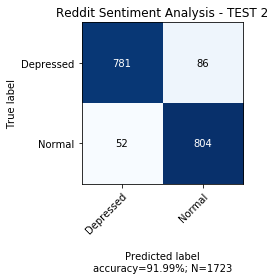

In [106]:
preds2 = []

for i in test_df["Message"]:
    pred = learner_class.predict(i)
    preds2.append(pred)
    print(pred)

cnf_test2 = confusion_matrix(
    [0 if i == "Depressed" else 1 for i in test_df["Sentiment"]], 
    [int(i[0]) for i in preds2],
)



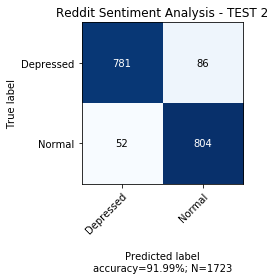

In [107]:
cm_plot(
    cm=cnf_test2,
    classes=np.unique(y), 
    cm_fig_path="C:/Users/jquin/Desktop/Projects/Twitts/cnf_reddit.png",
    title="Reddit Sentiment Analysis - TEST 2"
)

In [108]:
accuracy = balanced_accuracy_score(
        [0 if i == "Depressed" else 1 for i in test_df["Sentiment"]], 
        [int(i[0]) for i in preds2]
    )
print("-----------------------------------------------------------------")
print("RNN Test Accuracy: %.2f%%" % (accuracy * 100.0))
print("-----------------------------------------------------------------")
print(
    classification_report(
        [0 if i == "Depressed" else 1 for i in test_df["Sentiment"]], 
        [int(i[0]) for i in preds2],
        target_names=list(np.unique(y))
    )
)

-----------------------------------------------------------------
RNN Test Accuracy: 92.00%
-----------------------------------------------------------------
              precision    recall  f1-score   support

   Depressed       0.94      0.90      0.92       867
      Normal       0.90      0.94      0.92       856

    accuracy                           0.92      1723
   macro avg       0.92      0.92      0.92      1723
weighted avg       0.92      0.92      0.92      1723



In [116]:
learner_class.export("final_model.pkl")

In [139]:
learner_class.predict("Just end my life")

C:\Users\jquin\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.6222, 0.3778]))